In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as TreeC
from sklearn.ensemble import RandomForestClassifier as ForestC
from sklearn.ensemble import AdaBoostClassifier as AdaboostC
from sklearn.ensemble import GradientBoostingClassifier as GboostC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [2]:
cars = pd.read_csv('/kaggle/input/carsdata/cars.csv')
display(cars.head(n=10))
np.shape(cars)

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.
5,23.0,8,350,125,3900,17,1980,US.
6,13.0,8,351,158,4363,13,1974,US.
7,14.0,8,440,215,4312,9,1971,US.
8,25.4,5,183,77,3530,20,1980,Europe.
9,37.7,4,89,62,2050,17,1982,Japan.


(261, 8)

> *target : brand column (which is a country not really a brand we may change the name of  the column)*
>

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  261 non-null    object 
 3    hp           261 non-null    int64  
 4    weightlbs    261 non-null    object 
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 16.4+ KB


> *no null values nor missed one great😁*

> *3 values considered candidate categorical (object)*
- cubicinches ⚠️ we need to check wheather these values varies alot or we can consider it categories🤔⁉️
  - https://spicerparts.com/calculators/engine-displacement-calculator
  - https://www.quora.com/When-people-refer-to-the-cubic-inches-of-an-automobile-engine-what-are-they-talking-about
  - >To measure the volume of a cylinder, you would simply measure the top area and multiply it by its height, or depth, depending on perspective. The area is calculated as the square of its radius multiplied by pi, which is a geometric constant measured as 3.14 

- weightlbs ⚠️ we need to check wheather these values varies alot or we can consider it categories🤔⁉️
 - it should be a number the average weight for a vechile in general (Google search) ~2000~to~4000
 
    "small autos usually way around 2,500 pounds and large automobiles about 4,200 pounds. SUVs or trucks can range from 3,500 pounds to over 6,000 pounds"
- brand (Lable) ✅ cat


In [4]:
# to answer it we check the categorical candidates to see how they values varies 
cars.describe(include='O')

,cubicinches,weightlbs,brand
count,261,261,261
unique,75,240,3
top,97,,US.
freq,16,3,162


> concolude that weightlbs varies alot 91.9% are unique values (not ❌ categorical)

> for cubicinches it's 28.7% considering that the size of the dataset not huge we need further invesigation but mostly it's not categorical but let's see the histogram


In [5]:
cars.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

ooooooooohh no🤐 the one who named these columns was ... anyway some column names have a space before the name 

In [6]:
for col in cars.columns:
    cars.rename(columns={col: col.strip()}, inplace=True)

In [7]:
cars.columns

Index(['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60',
       'year', 'brand'],
      dtype='object')

In [8]:
# change data type of weightlbs
# cars['weightlbs'] = pd.to_numeric(cars['weightlbs'])
# we got an error as some cell is empty string ahhah😁 
# so to fix it let's fill it with NAN 
cars['weightlbs'] = pd.to_numeric(cars['weightlbs'], errors='coerce')



In [9]:
# as you might guessed now we have a NaN value one atleast we should deal with
cars.isna().sum()
# actually 3 ⚠️ 

mpg            0
cylinders      0
cubicinches    0
hp             0
weightlbs      3
time-to-60     0
year           0
brand          0
dtype: int64

In [10]:
cars.cubicinches.value_counts()

97     16
318    13
98     13
250    13
350    12
       ..
262     1
340     1
141     1
80      1
454     1
Name: cubicinches, Length: 75, dtype: int64

In [11]:
# let's just make it a number
cars['cubicinches'] = pd.to_numeric(cars['cubicinches'], errors='coerce')
# 2 nan values extra here
cars.isna().sum()


mpg            0
cylinders      0
cubicinches    2
hp             0
weightlbs      3
time-to-60     0
year           0
brand          0
dtype: int64

In [12]:
# let's fill them or drop 
# droping when we have few observations not too good I think
# for weightlbs I prefere to fill with the average as we can see its values varies more 
# but for cubicinchies I would use the most freq value '97'


In [13]:
cars['cubicinches'].mode()

0    97.0
Name: cubicinches, dtype: float64

In [14]:
cars['cubicinches'].mean()

200.9189189189189

In [15]:
cars['cubicinches'] = cars['cubicinches'].fillna(cars['cubicinches'].mode()[0])
cars['weightlbs'] = cars['weightlbs'].fillna(cars['weightlbs'].mean())

In [16]:
# checking ✅
cars.isna().sum()

mpg            0
cylinders      0
cubicinches    0
hp             0
weightlbs      0
time-to-60     0
year           0
brand          0
dtype: int64

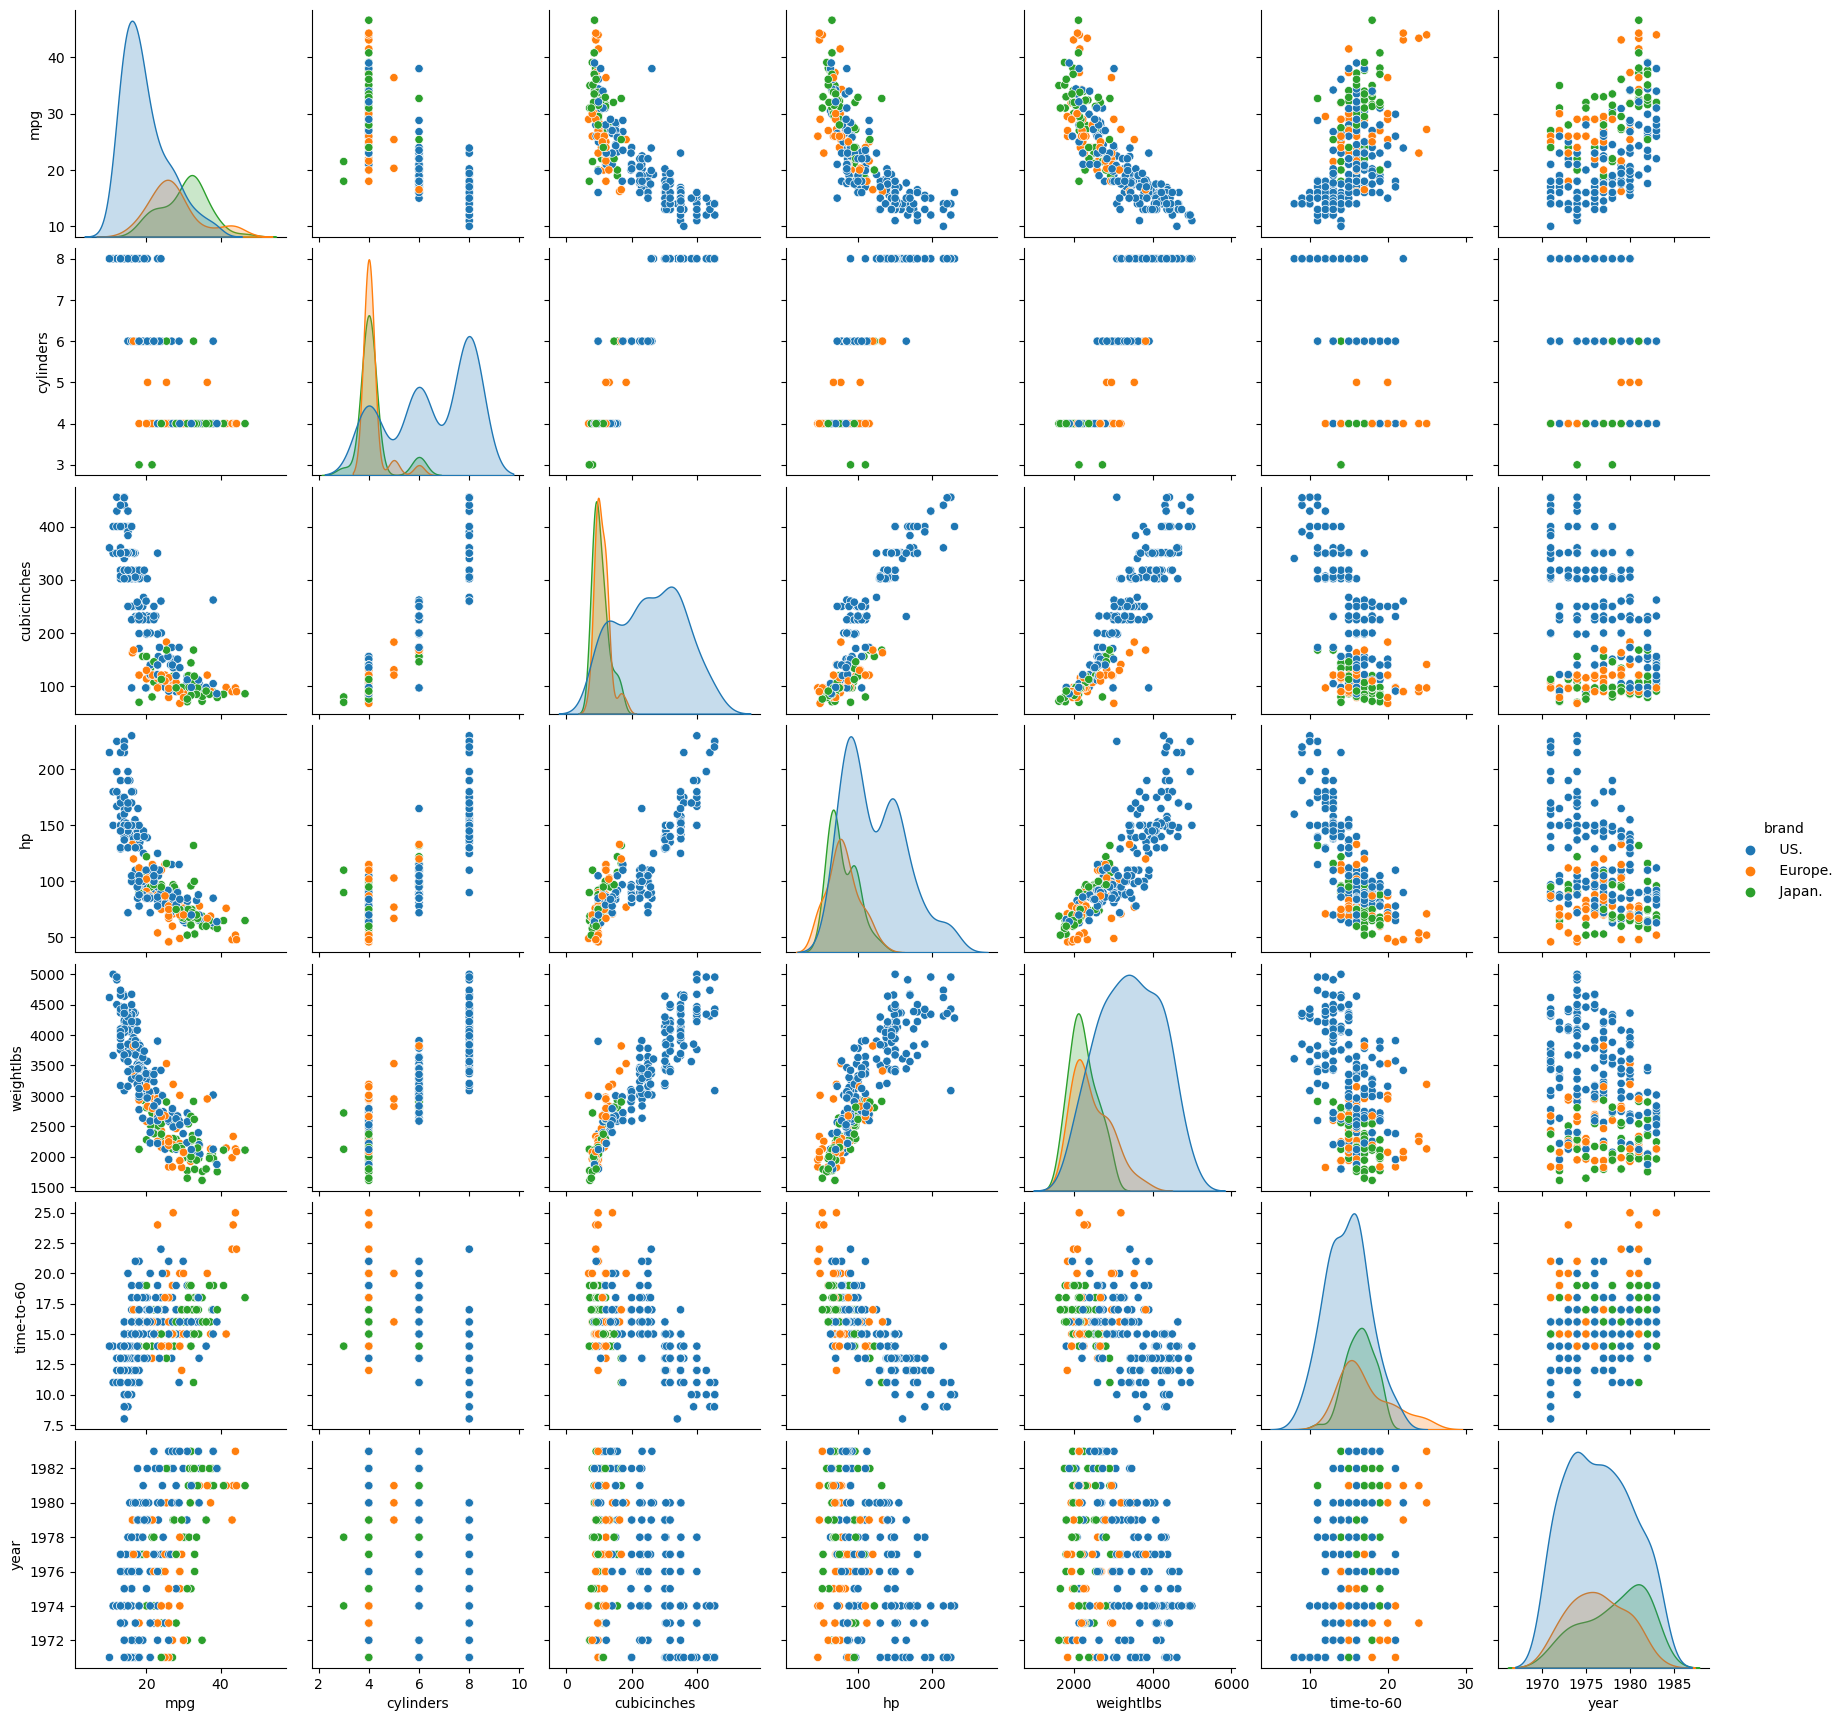

In [17]:
# plot of the data
sns.pairplot(cars, hue='brand')

>Takeaway
> Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.
https://towardsdatascience.com/do-decision-trees-need-feature-scaling-97809eaa60c6

In [18]:
# tree based model doesn't need scalling so let's jump to the models
# we need to split the data but seeing how the lable is distributed 
cars.brand.value_counts() 
# USA => 62% Naive classifier 
# Japan => 19.5%
# Europe => 18.3%


 US.        162
 Japan.      51
 Europe.     48
Name: brand, dtype: int64

## Spliting the data 

In [19]:
y = cars['brand']
X = cars.iloc[:, :-1]
display(y,X) 


0           US.
1       Europe.
2           US.
3           US.
4           US.
         ...   
256         US.
257      Japan.
258         US.
259         US.
260         US.
Name: brand, Length: 261, dtype: object

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
0,14.0,8,350.0,165,4209.0,12,1972
1,31.9,4,89.0,71,1925.0,14,1980
2,17.0,8,302.0,140,3449.0,11,1971
3,15.0,8,400.0,150,3761.0,10,1971
4,30.5,4,98.0,63,2051.0,17,1978
...,...,...,...,...,...,...,...
256,17.0,8,305.0,130,3840.0,15,1980
257,36.1,4,91.0,60,1800.0,16,1979
258,22.0,6,232.0,112,2835.0,15,1983
259,18.0,6,232.0,100,3288.0,16,1972


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=6, test_size=0.3, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [21]:
display(x_train, y_train)

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
110,20.0,4,97.0,88,2279.0,19,1974
37,21.5,3,80.0,110,2720.0,14,1978
142,32.0,4,144.0,96,2665.0,14,1983
193,15.0,8,350.0,145,4082.0,13,1974
207,18.0,6,250.0,88,3021.0,17,1974
...,...,...,...,...,...,...,...
35,22.4,6,231.0,110,3415.0,16,1982
226,10.0,8,360.0,215,4615.0,14,1971
152,14.0,8,455.0,225,4425.0,10,1971
98,18.2,8,318.0,135,3830.0,15,1980


110     Japan.
37      Japan.
142     Japan.
193        US.
207        US.
        ...   
35         US.
226        US.
152        US.
98         US.
240        US.
Name: brand, Length: 182, dtype: object

In [22]:
display(x_test, y_test)

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
220,17.5,6,258.0,95,3193.0,18,1977
10,34.0,4,108.0,70,2245.0,17,1983
66,26.0,4,97.0,46,1950.0,21,1974
103,34.2,4,105.0,70,2200.0,13,1980
71,27.0,4,112.0,88,2640.0,19,1983
...,...,...,...,...,...,...,...
167,26.0,4,156.0,92,2585.0,15,1983
47,22.0,4,122.0,86,2395.0,16,1973
258,22.0,6,232.0,112,2835.0,15,1983
56,19.0,6,156.0,108,2930.0,16,1977


220         US.
10       Japan.
66      Europe.
103         US.
71          US.
         ...   
167         US.
47          US.
258         US.
56       Japan.
44          US.
Name: brand, Length: 79, dtype: object

# Default Models to choose one


In [23]:
models = [
    ('Decision Tree', TreeC()),
    ('Random Forest', ForestC()),
    ('Ada boost', AdaboostC()),
    ('Gradient boost', GboostC())
]
# param_grid = {

# }
# grid_search = GridSearchCV(estimator=models, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# grid_search.score(x_test, y_test)
results = {}
for name, model in models:
    model.fit(x_train, y_train)
    results[name] = model.score(x_test, y_test)

print(results)


{'Decision Tree': 0.8227848101265823, 'Random Forest': 0.810126582278481, 'Ada boost': 0.7341772151898734, 'Gradient boost': 0.8607594936708861}


# improving models

In [24]:
Tree = TreeC()
Tree.fit(x_train, y_train)
Tree.score(x_test, y_test)

0.7974683544303798

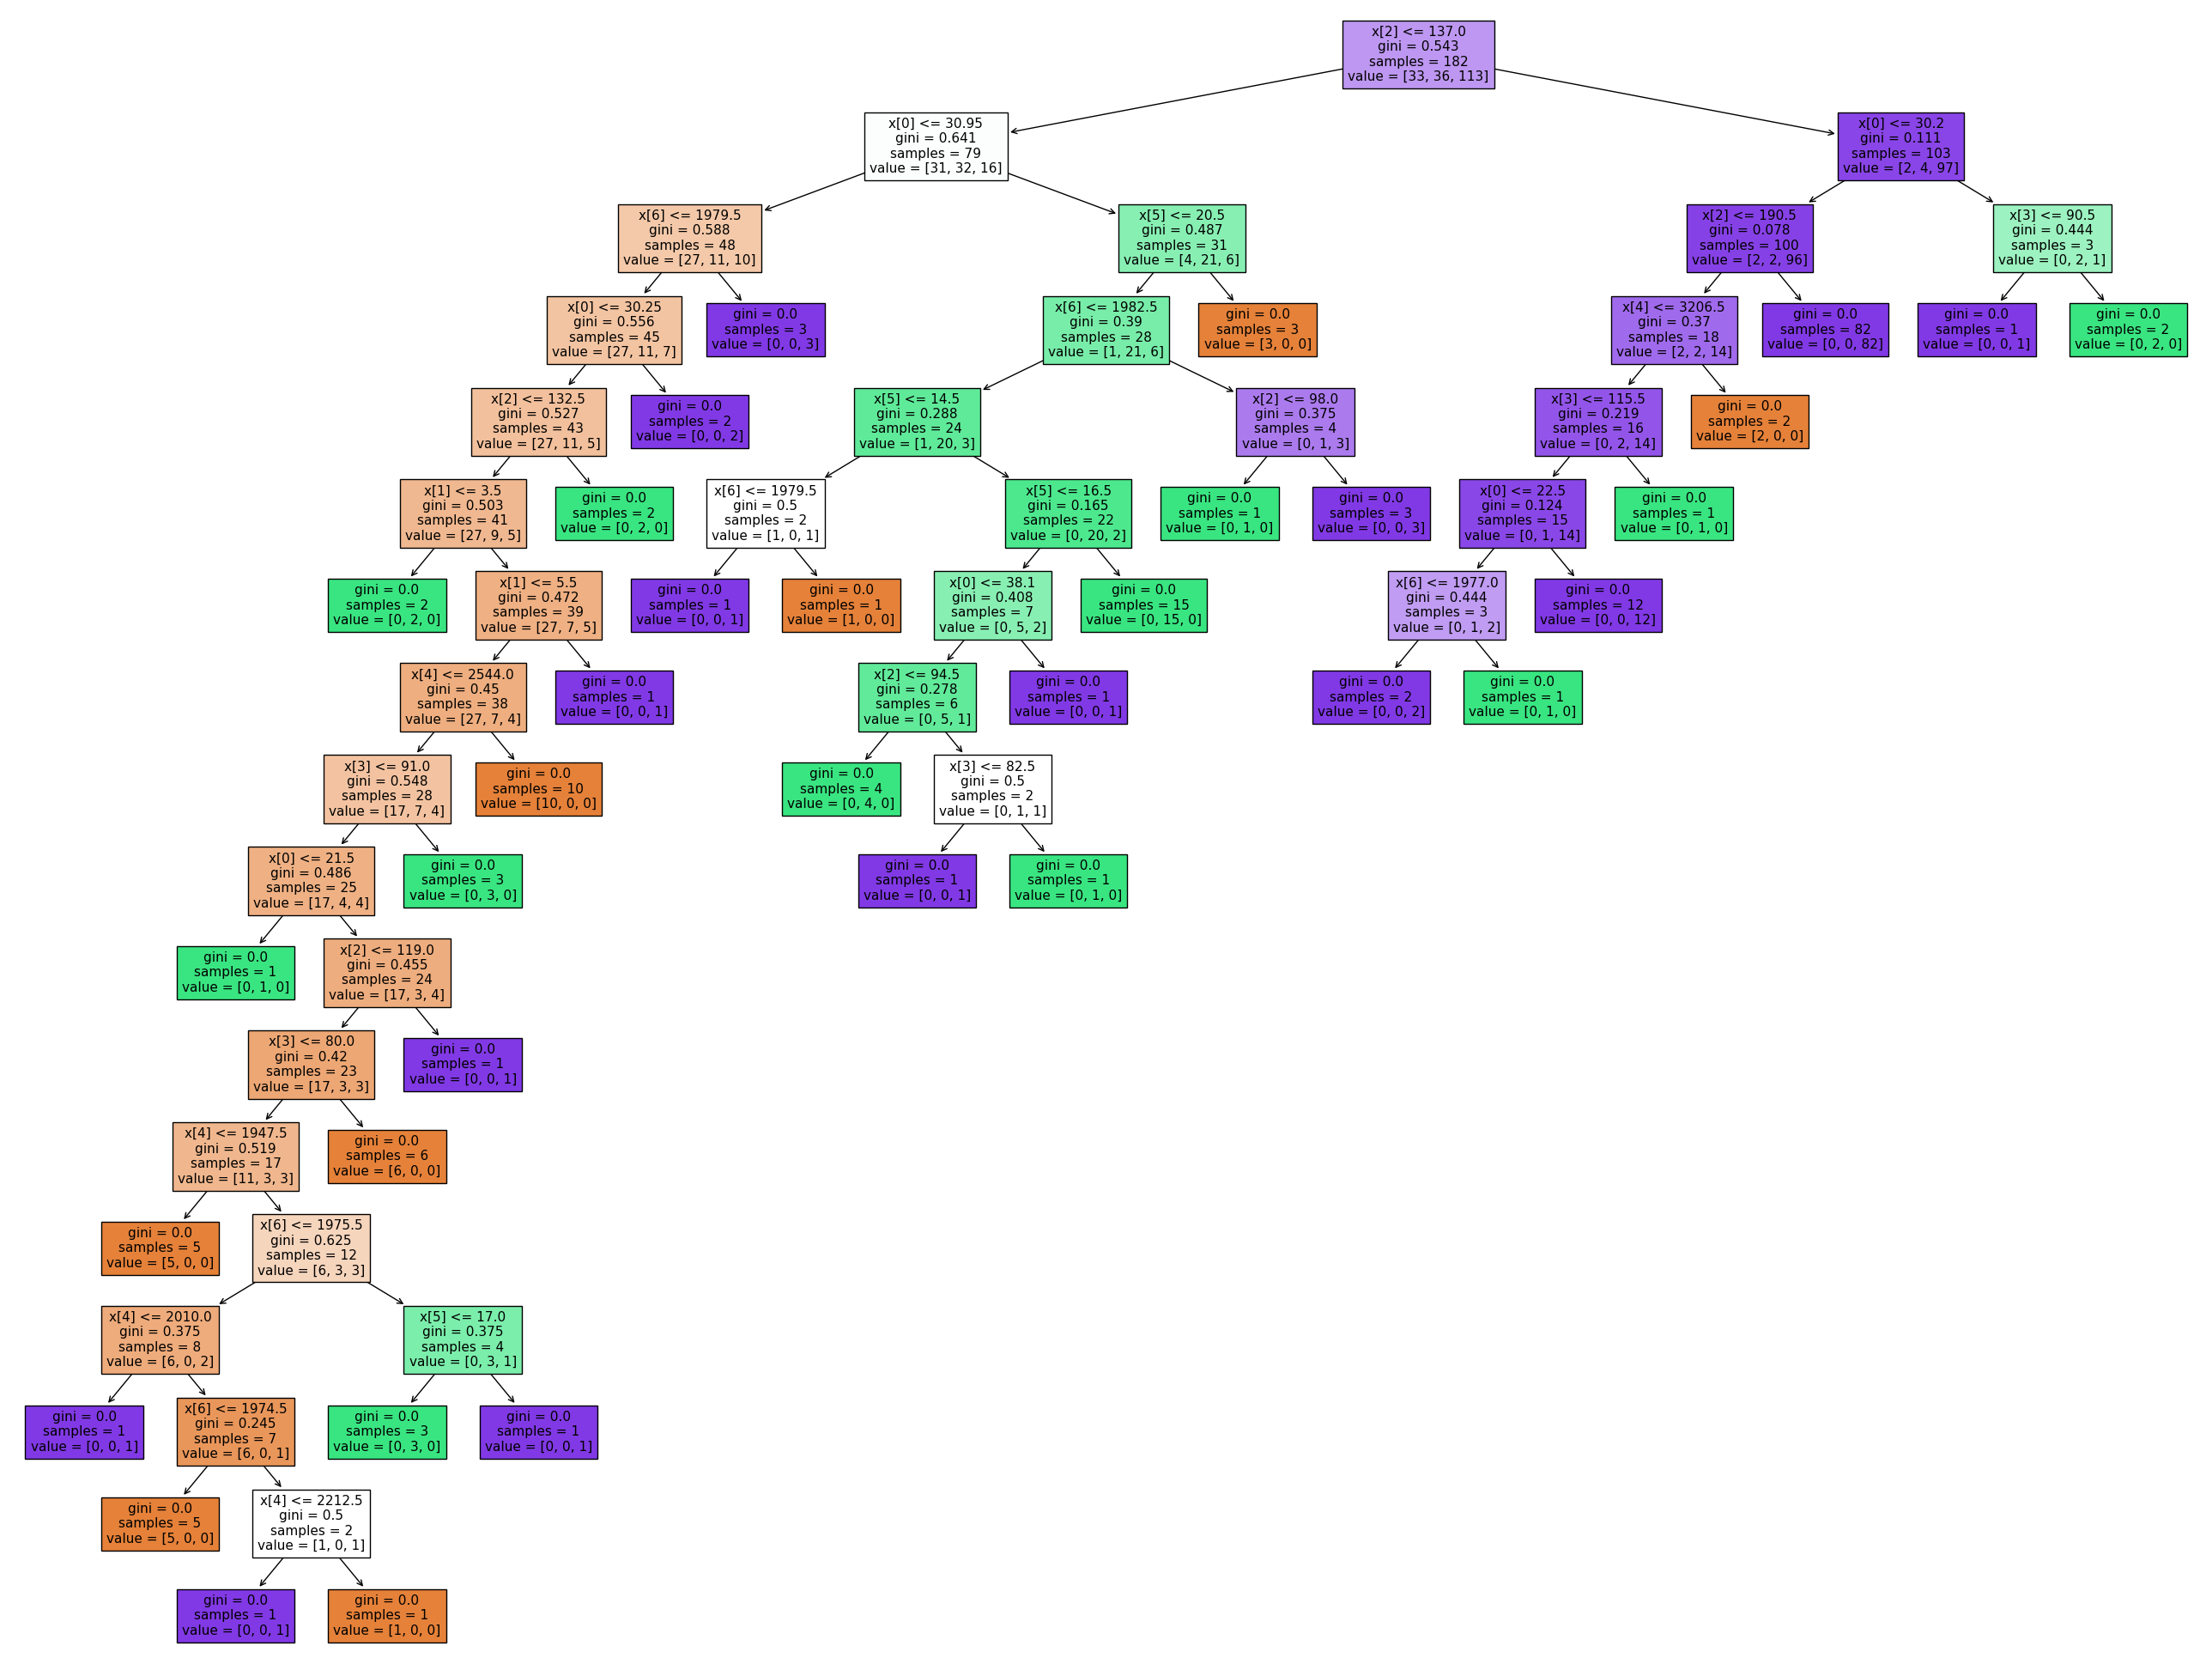

In [25]:
from sklearn.tree import plot_tree
plt.figure(figsize=(33, 25))
plot_tree(Tree, filled=True);

let's focus now we have weired Tree that is skewed to the right and maybe overfit so seeing that we can put parameters to generalize more like limiting the min_samples in a leaf and the other features to reduce the size of the tree

### Pruning the tree ✂️🌳 
### pre pruning

**[RECALL](https://hossam-ahmed.notion.site/Entropy-Information-Gain-Gini-Index-1fbaf1424fe8495f91b68d11a071a930?pvs=4)** 

- Pre-pruning is a technique that involves stopping the growth of the decision tree early to prevent overfitting.
- Hyperparameters like max_depth, min_samples_leaf, and min_samples_split can be tuned to control the growth of the tree.
- Sklearn's DecisionTreeClassifier offers these hyperparameters for pre-pruning.
- The GridSearchCV technique in Sklearn can be used to find the optimal hyperparameter values for the decision tree model.
- ***However, early stopping may face a challenge known as the "horizon" problem, where potentially fruitful splits are missed by stopping the tree's growth too early.***

### *Post Pruning*

- Post-pruning is a technique where the decision tree is allowed to grow to its maximum depth and then parts of the tree are removed to prevent overfitting.
- Subtrees of the full tree are evaluated using criteria such as mean squared error (MSE) for regression trees or classification error for classification trees.
- Post pruning involves converting leaves to nodes and removing subtrees based on the evaluation criteria.
- The challenge with post pruning is that **evaluating every branch of a large tree can be computationally expensive.**

In [26]:
# train the decision tree model with post-pruning
path = Tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas
models = []
for i, ccp_alpha in enumerate(ccp_alphas):
    model = TreeC(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(x_train, y_train)
    print(f"Accuracy with pruning #{i+1}:", model.score(x_test, y_test))
    models.append(model)





Accuracy with pruning #1: 0.8354430379746836
Accuracy with pruning #2: 0.810126582278481
Accuracy with pruning #3: 0.810126582278481
Accuracy with pruning #4: 0.7974683544303798
Accuracy with pruning #5: 0.7974683544303798
Accuracy with pruning #6: 0.7974683544303798
Accuracy with pruning #7: 0.8227848101265823
Accuracy with pruning #8: 0.8227848101265823
Accuracy with pruning #9: 0.8227848101265823
Accuracy with pruning #10: 0.8227848101265823
Accuracy with pruning #11: 0.7974683544303798
Accuracy with pruning #12: 0.7848101265822784
Accuracy with pruning #13: 0.7468354430379747
Accuracy with pruning #14: 0.7468354430379747
Accuracy with pruning #15: 0.7341772151898734
Accuracy with pruning #16: 0.7341772151898734
Accuracy with pruning #17: 0.7341772151898734
Accuracy with pruning #18: 0.7341772151898734
Accuracy with pruning #19: 0.7341772151898734
Accuracy with pruning #20: 0.6962025316455697
Accuracy with pruning #21: 0.6835443037974683
Accuracy with pruning #22: 0.6582278481012658

the more we go down decreasing the number of leaves the model became underfit 
> note that the lowest model is just  like the Naive classifier with 62% 
> from model#10 -> 7 accuracy sound to be more realistic as even when we changed number of leaves still generalise well
> not like in the first and second model drop from 83%->81%

Model 0


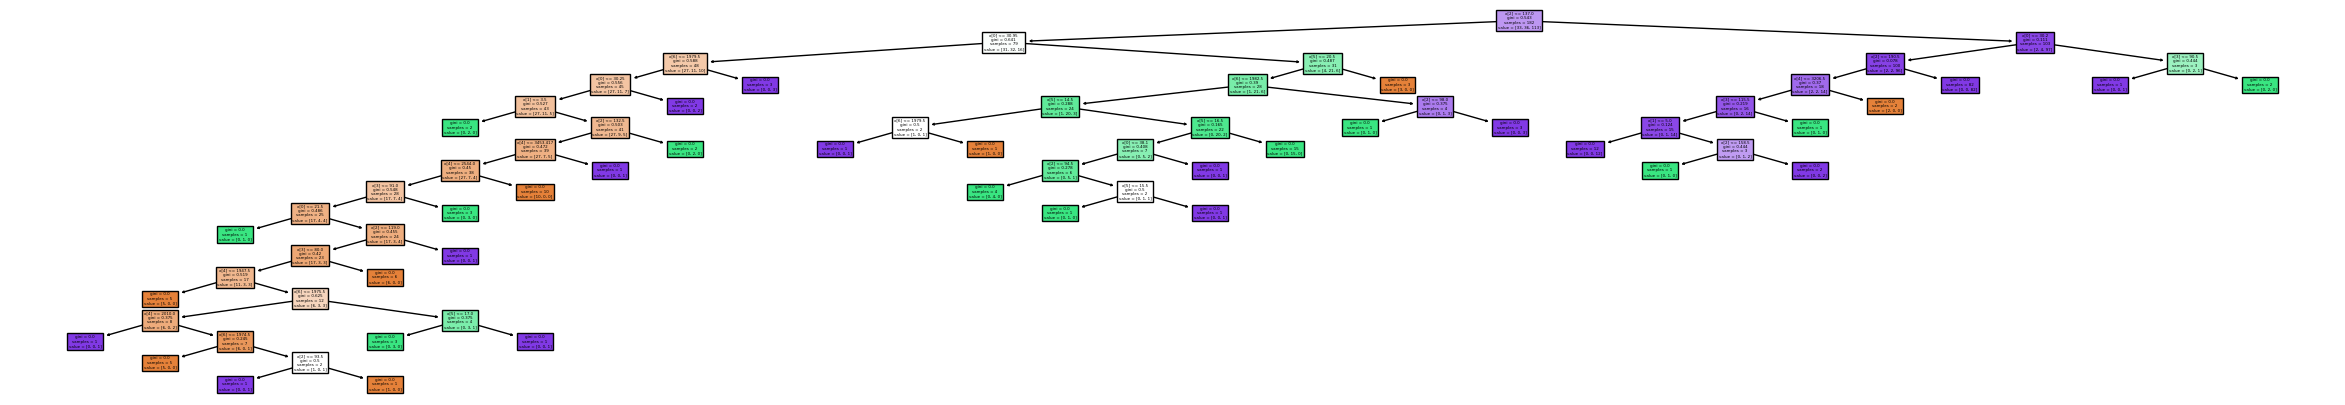

Model 2


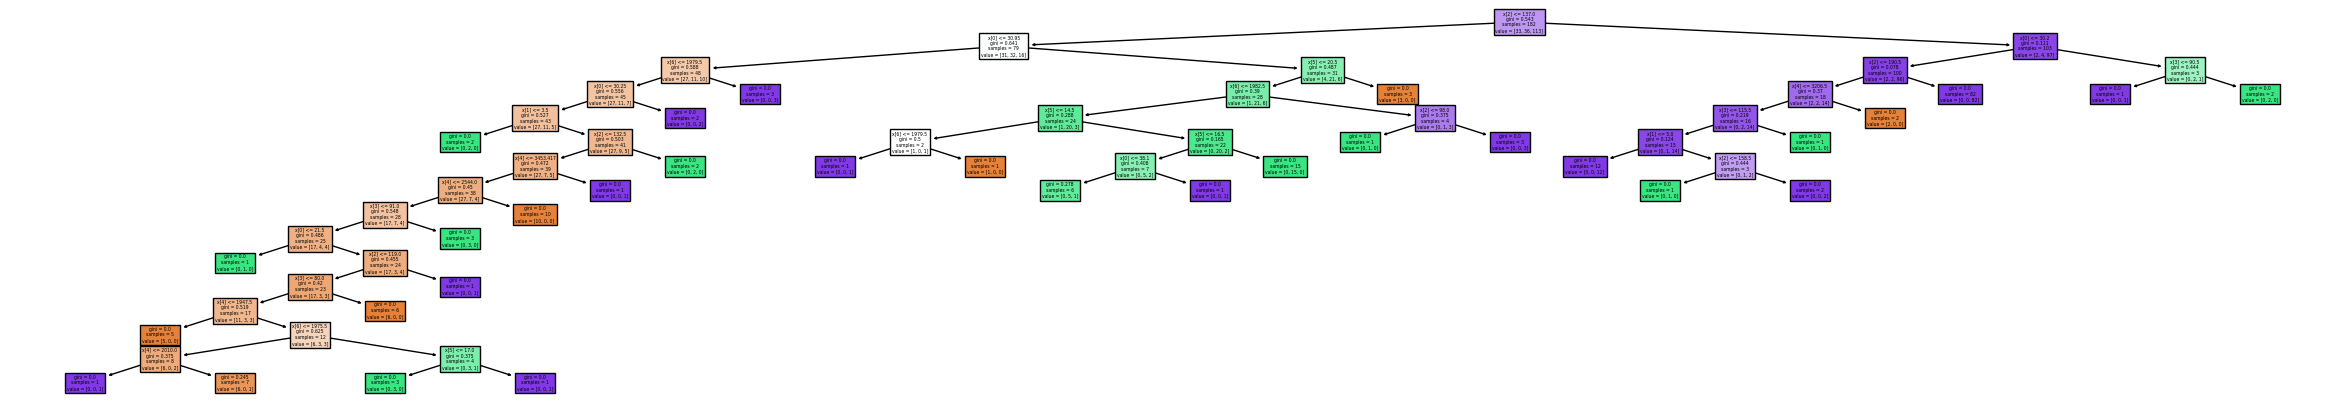

Model 4


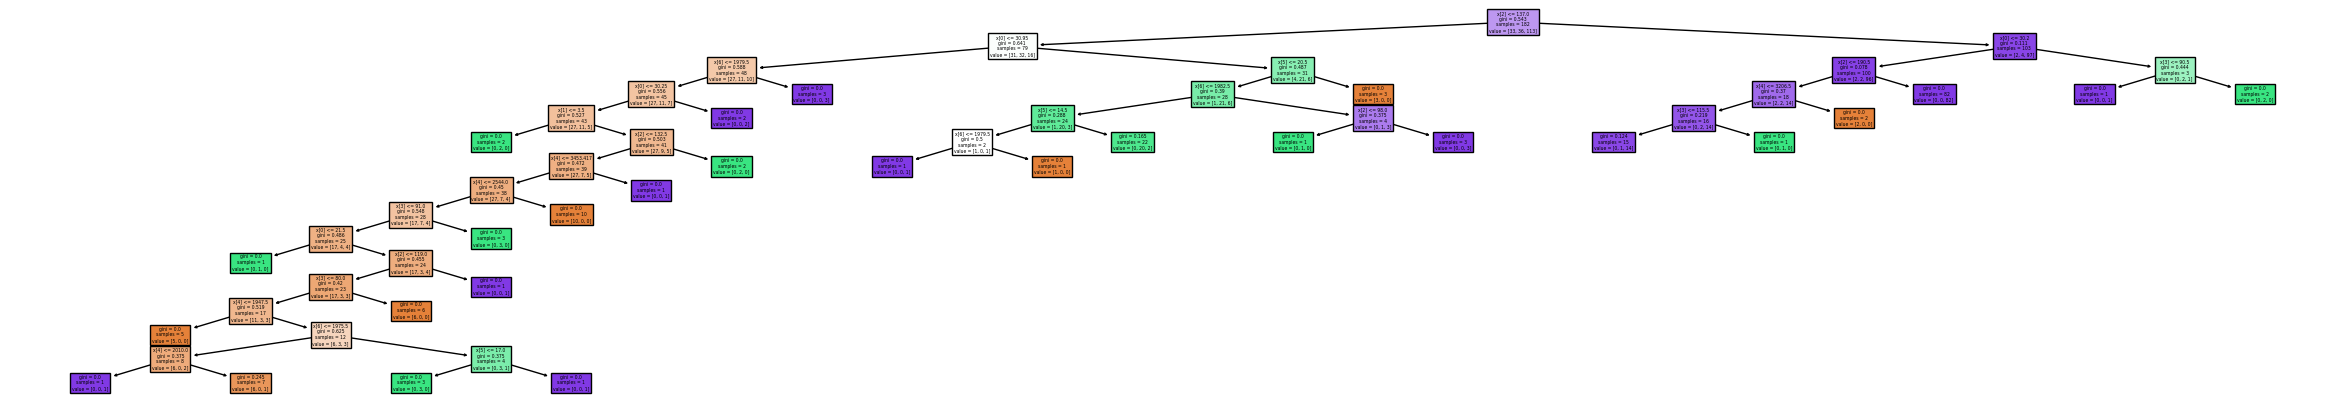

Model 6


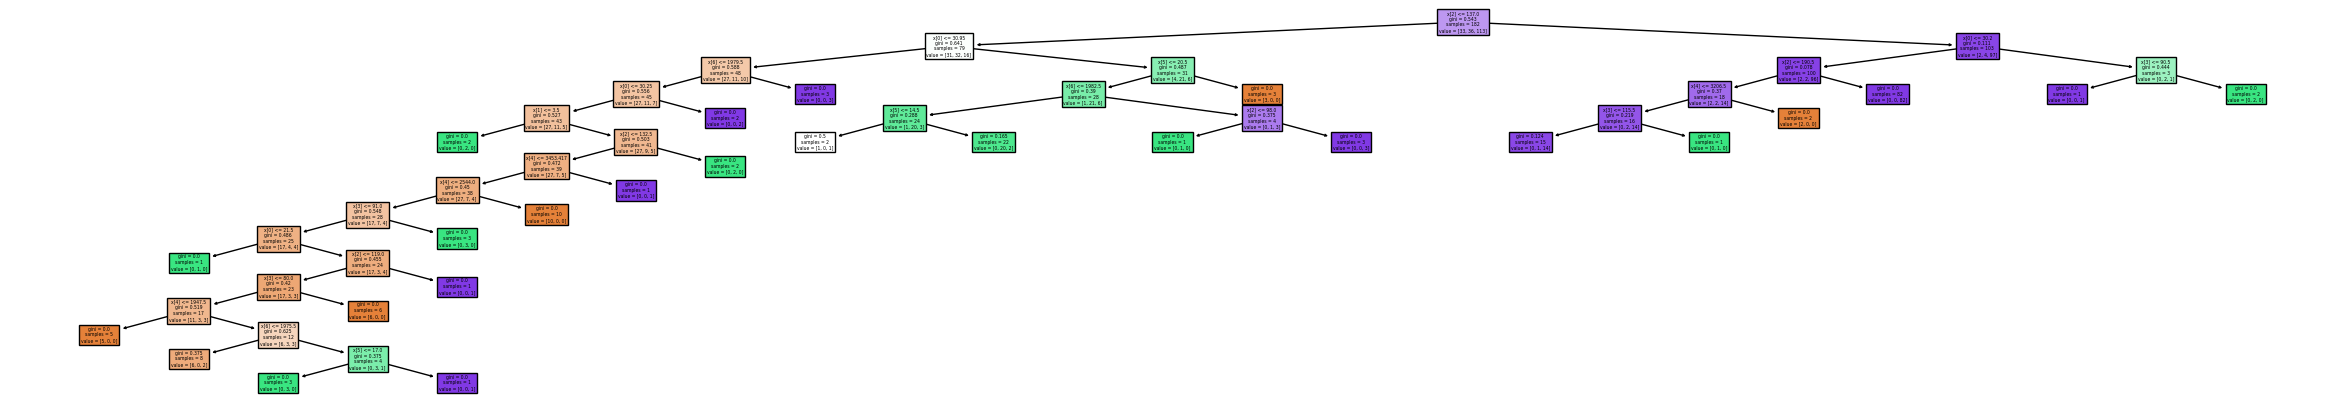

Model 7


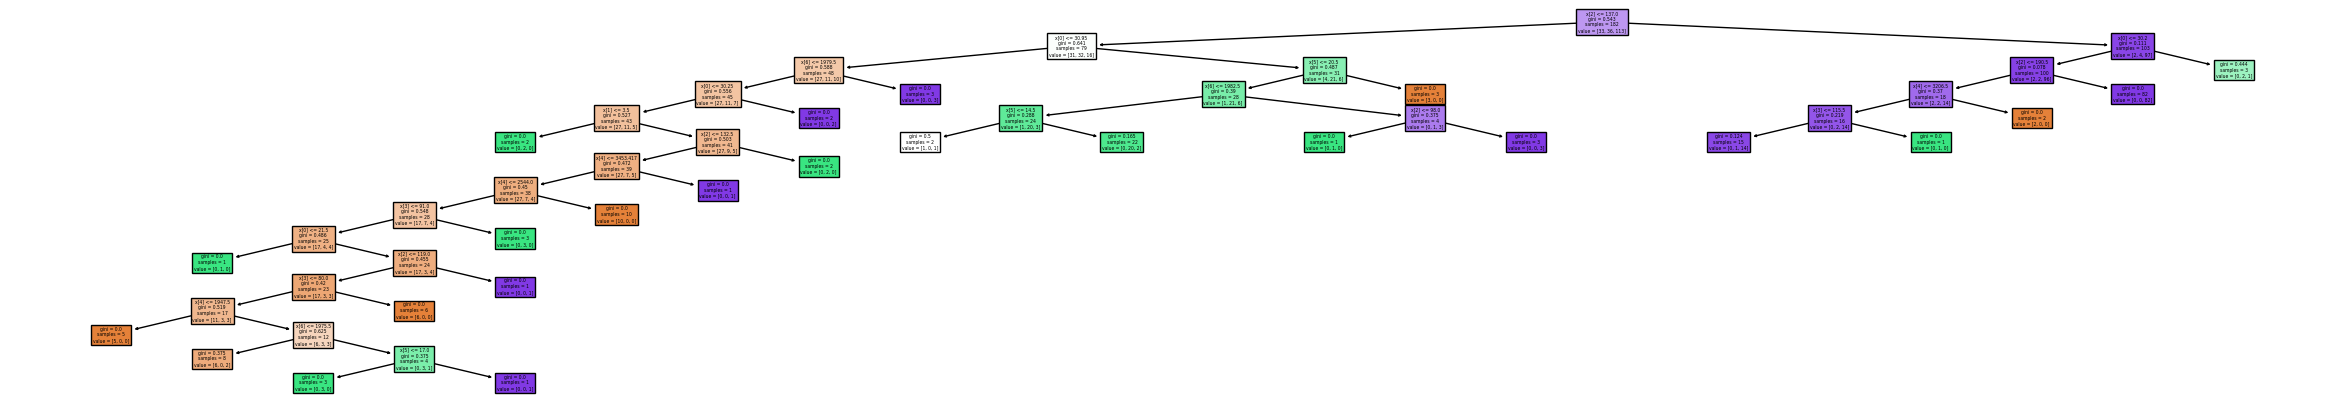

Model 9


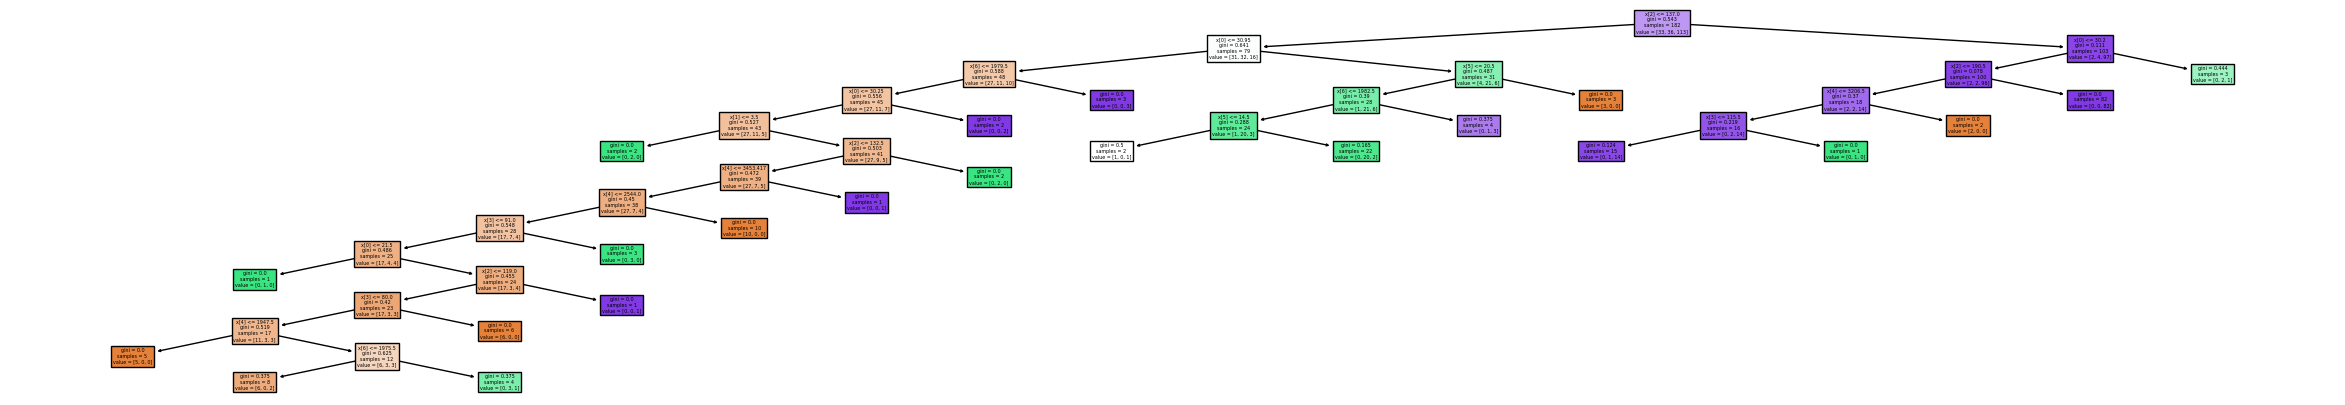

Model 10


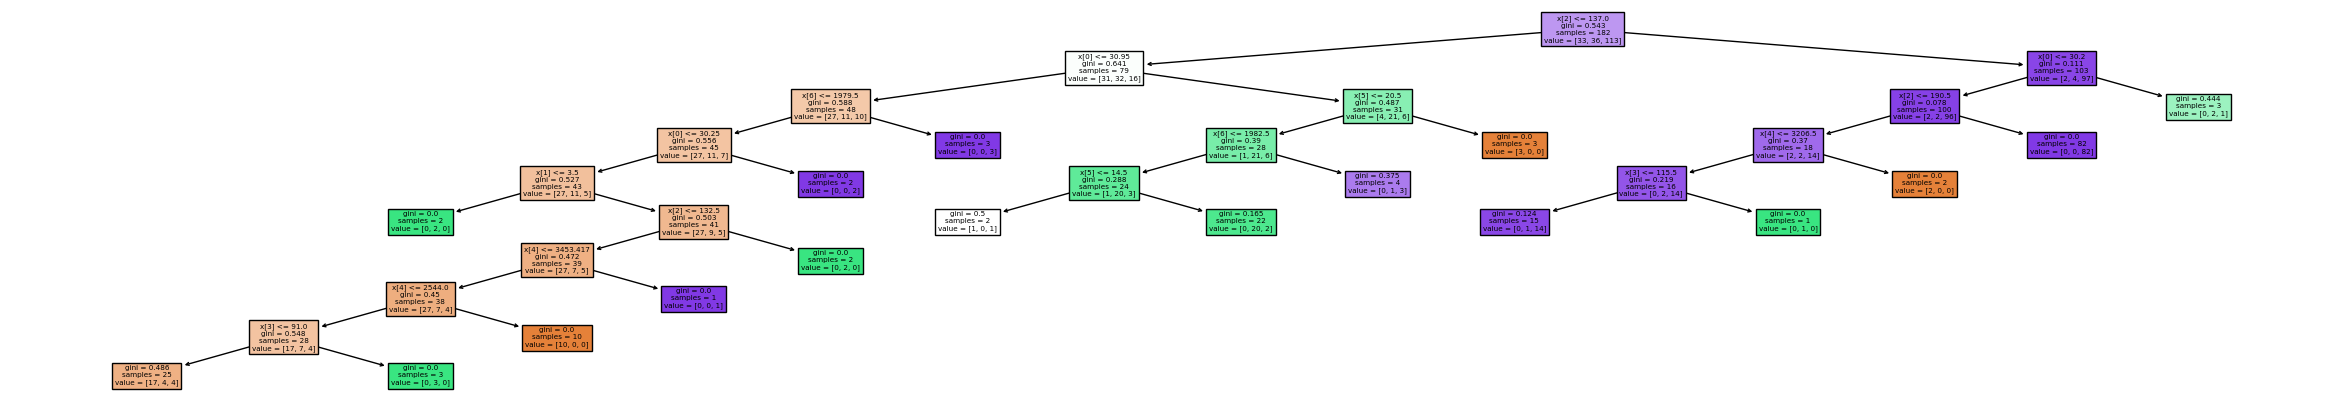

Model 11


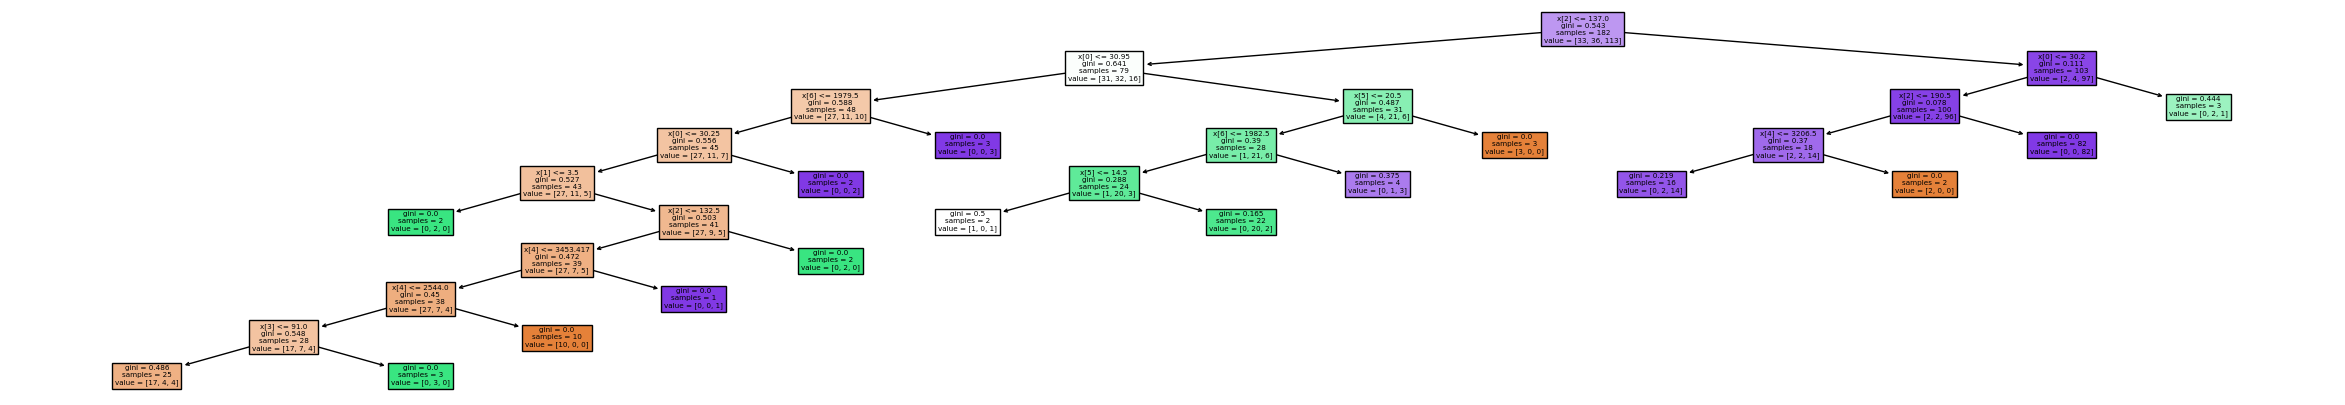

Model 14


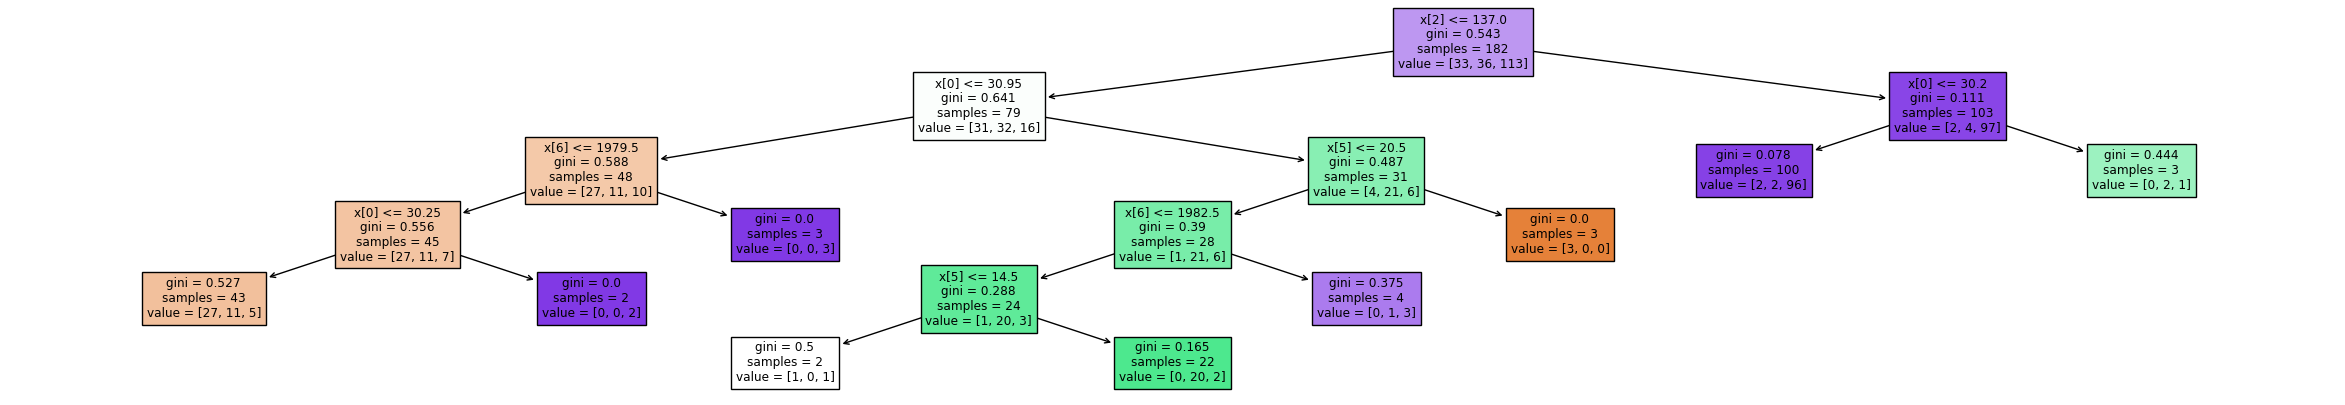

Model 17


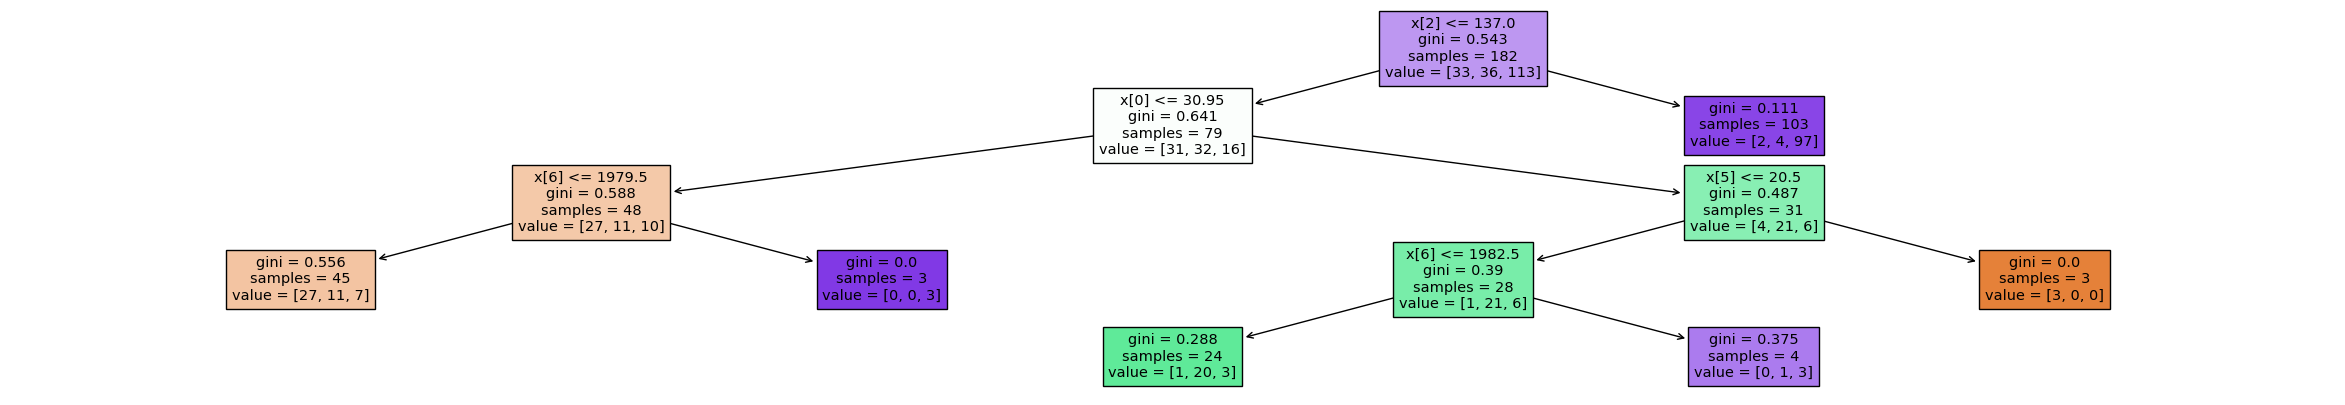

Model 20


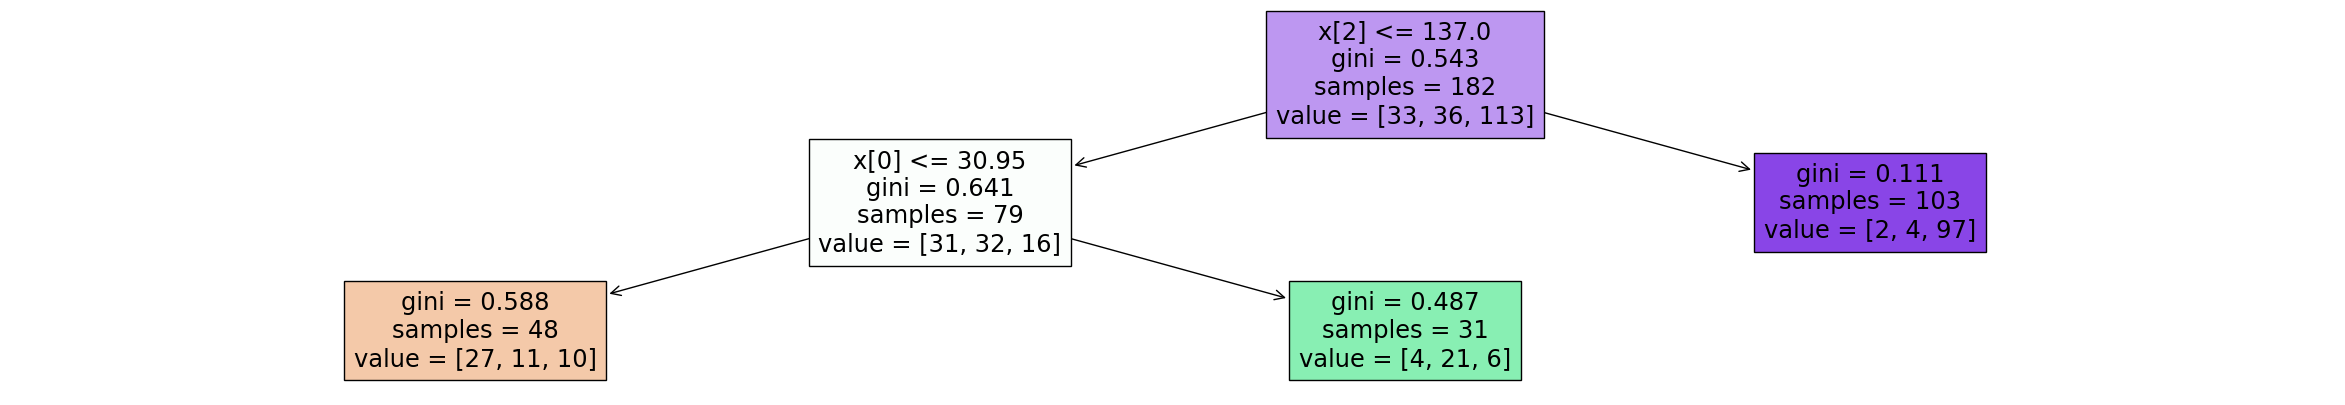

Model 22


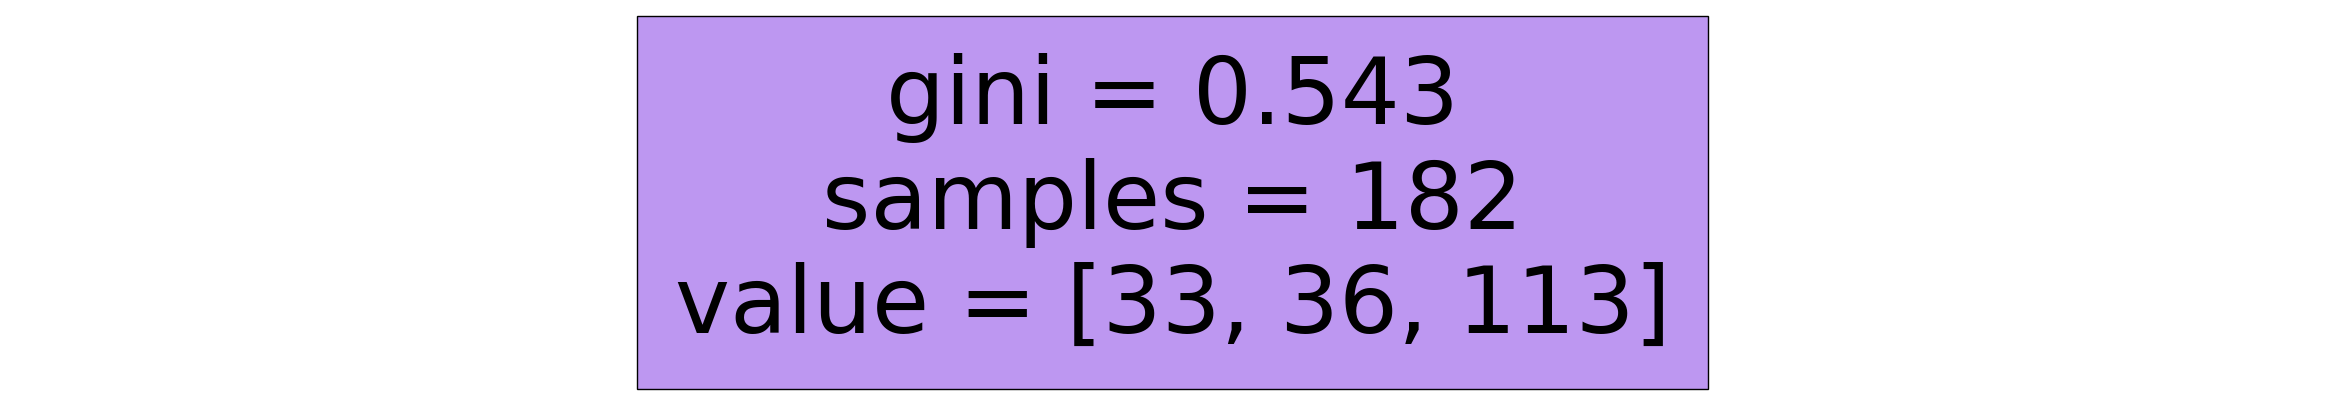

In [27]:
# visualize the pruned decision tree
choosen_models = [0,2, 4, 6, 7, 9, 10, 11, 14, 17, 20, 22]
for m in choosen_models:
    plt.figure(figsize=(30, 5))
    print(f"Model {m}")
    plot_tree(models[m], filled=True)
    plt.show()

✂️💇‍♂️💈when you over pruning decision trees
 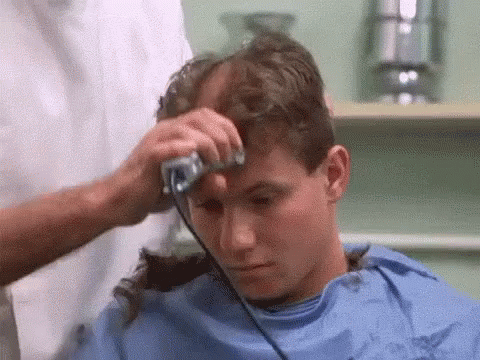